# Amharic Character Recognition


### Importing Libraries


In [3]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


plt.rcParams['font.family'] = 'Abyssinica SIL' 

### Loading and Preprocessing Data


In [4]:
def load_images_and_labels(dataset_dir):
    data = []
    labels = []
    for root, _, files in os.walk(dataset_dir):
        label = os.path.basename(root)
        for file in files:
            with Image.open(os.path.join(root, file)) as img:
                img_resized = img.resize((64, 64)).convert('L')
                img_array = np.array(img_resized).flatten()
                data.append(img_array)
                labels.append(label)
    combined = list(zip(data, labels))
    random.shuffle(combined)
    data[:], labels[:] = zip(*combined)
    
    return data, labels

dataset_dir = "/home/hailemicael/ml_pro/dataset"
data, labels = load_images_and_labels(dataset_dir)

In [5]:
def normalize_data(data):
    data = np.array(data)
    max_val = np.max(data)
    min_val = np.min(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

data = normalize_data(data)
print("Normalized data shape:", data.shape)

Normalized data shape: (4200, 4096)


### Visualizing Data


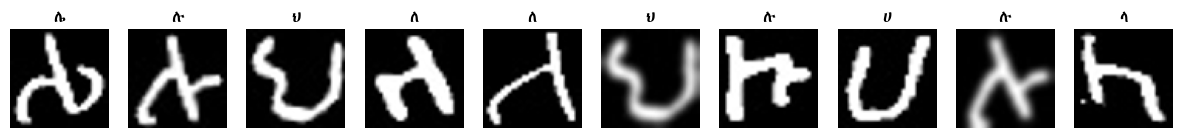

In [6]:
def visualize_data(data, labels, num_images=10):
    random_indices = np.random.choice(len(data), num_images, replace=False)
    plt.figure(figsize=(15, 3))
    for i, index in enumerate(random_indices):
        plt.subplot(1, num_images, i+1)
        img = data[index].reshape(64, 64)
        plt.imshow(img, cmap='gray')
        plt.title(labels[index])
        plt.axis('off')
    plt.show()

visualize_data(data, labels)


In [7]:
def visualize_data(data, labels, num_images=10, save_path = None):
    random_indices = np.random.choice(len(data), num_images, replace=False)
    plt.figure(figsize=(15, 3))
    for i, index in enumerate(random_indices):
        plt.subplot(1, num_images, i+1)
        img = data[index].reshape(64, 64)
        plt.imshow(img, cmap='gray')
        plt.title(labels[index])
        plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the figure if save_path is provided
        plt.close()  # Close the figure to release memory
    else:
        plt.show()

# Visualize PCA Analyzed Images and save themimport os

# Define the directory path
directory = "/home/hailemicael/ml_pro/Images/"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Visualize PCA Analyzed Images and save them
visualize_data(data, labels, num_images=10,save_path="/home/hailemicael/ml_pro/Images/pca_analyzed_image.png")


### Splitting Data


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


### Visualizing Training and Testing Data


Training Images:


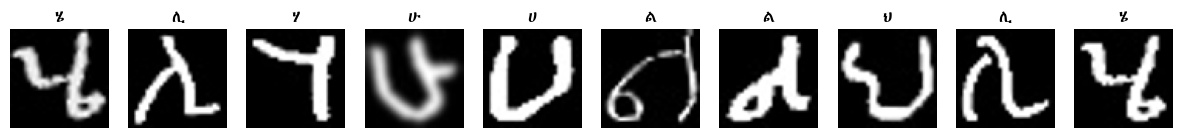

Testing Images:


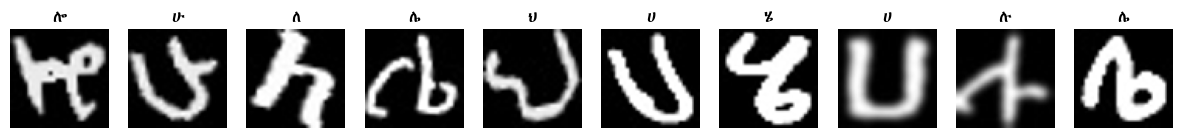

In [9]:
print("Training Images:")
visualize_data(X_train, y_train)

print("Testing Images:")
visualize_data(X_test, y_test)

### Applying PCA


In [10]:
def apply_pca(data, alpha=0.95):
    mean = np.mean(data, axis=0)
    centered_data = data - mean

    cov_matrix = np.dot(centered_data.T, centered_data) / (centered_data.shape[0] - 1)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    evr = eig_values / np.sum(eig_values)
    cvr = np.cumsum(evr)
    k = np.argmax(cvr >= alpha) + 1

    print(f"Using {k} components to retain {cvr[k-1]*100:.2f}% of the variance")
    reduced_data = np.dot(centered_data, eig_vectors[:, :k])
    return reduced_data, eig_vectors, k

transformed_x_train, eig_vectors_pca_train, k = apply_pca(X_train, alpha=0.85)
centered_x_test = X_test - np.mean(X_train, axis=0)
transformed_x_test = np.dot(centered_x_test, eig_vectors_pca_train[:, :k])


Using 48 components to retain 85.26% of the variance


### Visualizing PCA Analyzed Images


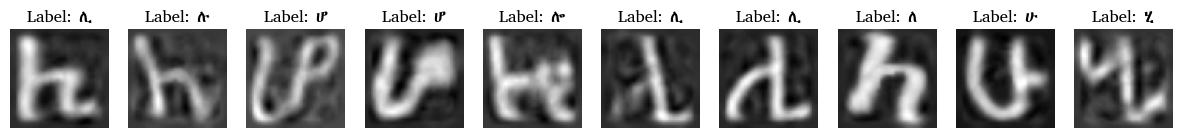

In [11]:
def pca_analyzed_images(data, eig_vectors, or_data, or_labels, or_shape=(64, 64), num_images=10):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        reconstructed_image = np.dot(data[i], eig_vectors[:, :data.shape[1]].T) + np.mean(or_data, axis=0)
        pca_analyzed_image = reconstructed_image.reshape(or_shape)

        axs[i].imshow(pca_analyzed_image, cmap='gray')
        axs[i].set_title(f"Label: {or_labels[i]}")
        axs[i].axis('off')
    plt.show()

pca_analyzed_images(transformed_x_train, eig_vectors_pca_train, X_train, y_train)


### Applying LDA


In [12]:
def LDA(data, labels, k=1):
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    class_means = np.array([np.mean(data[labels == label], axis=0) for label in unique_labels])
    Sw = sum(np.dot((data[labels == label] - class_means[i]).T, (data[labels == label] - class_means[i]))
             for i, label in enumerate(unique_labels))

    overall_mean = np.mean(data, axis=0)
    Sb = sum(len(data[labels == label]) * np.outer(class_means[i] - overall_mean, class_means[i] - overall_mean)
             for i, label in enumerate(unique_labels))

    eig_values, eig_vectors = np.linalg.eigh(np.linalg.inv(Sw) @ Sb)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    return eig_vectors[:, :k]


lda_space = LDA(transformed_x_train, y_train, k=100) 
train_lda_projected = np.dot(transformed_x_train, lda_space)
test_lda_projected = np.dot(transformed_x_test, lda_space)


### Classifiers


In [13]:
svm = SVC()
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()


### Training and Evaluating Classifiers



Results with no dimensionality reduction:
SVM Results:
Accuracy: 0.9488095238095238
Precision: 0.9505727631435299
F1 Score: 0.9489885611609874


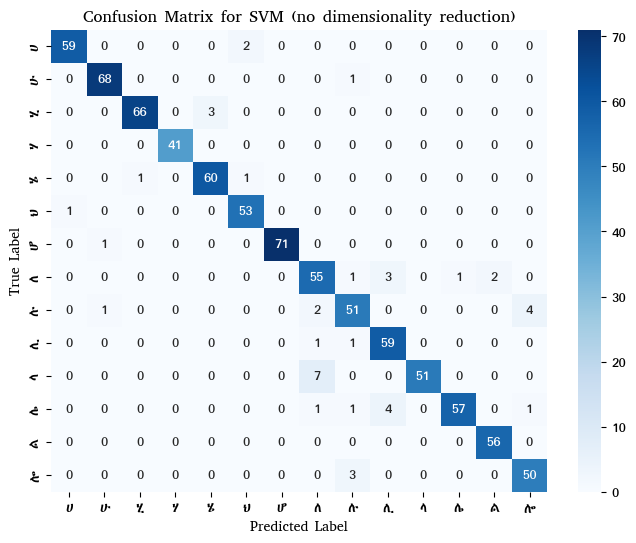


Results with no dimensionality reduction:
KNN Results:
Accuracy: 0.830952380952381
Precision: 0.8363242872055732
F1 Score: 0.8319084432613858


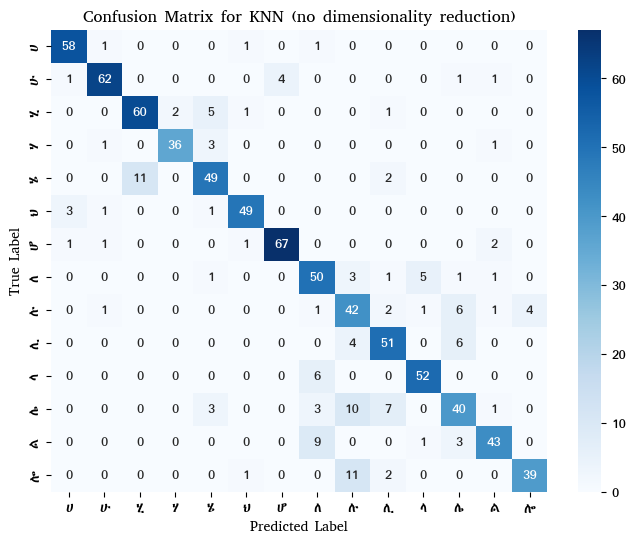


Results with no dimensionality reduction:
Logistic Regression Results:
Accuracy: 0.9154761904761904
Precision: 0.9168066293599084
F1 Score: 0.9155860972824051


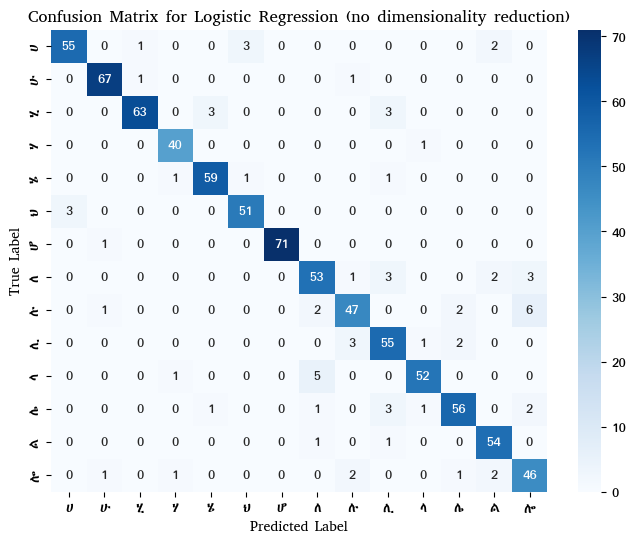


Results with after applying PCA:
SVM Results:
Accuracy: 0.9535714285714286
Precision: 0.9547909851177209
F1 Score: 0.9537381105615095


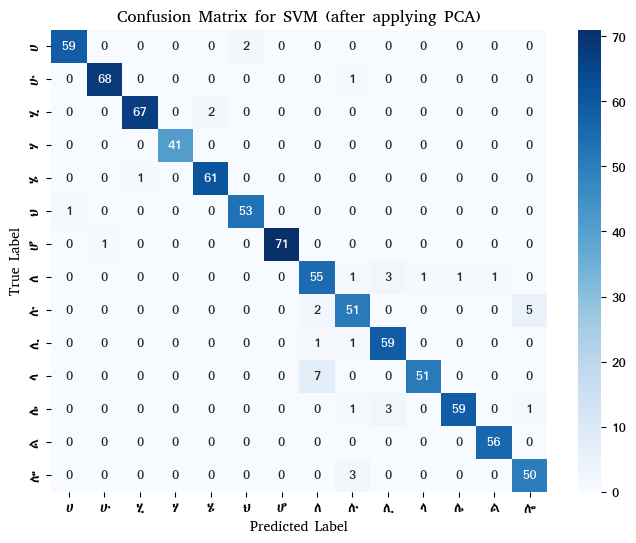


Results with after applying PCA:
KNN Results:
Accuracy: 0.8821428571428571
Precision: 0.8841469587997256
F1 Score: 0.8818743039915808


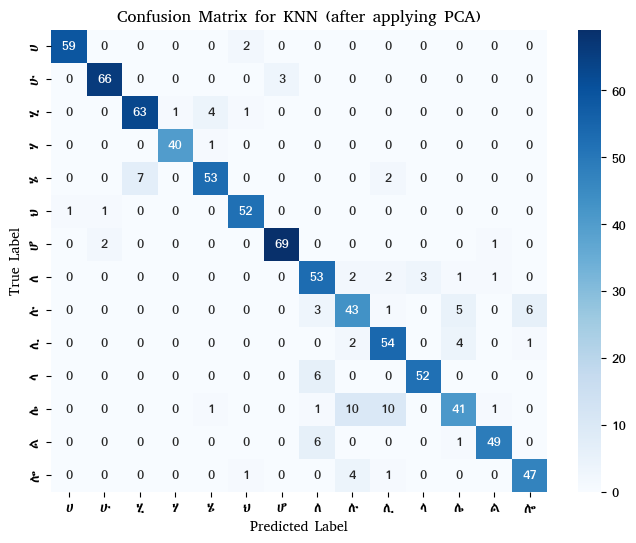


Results with after applying PCA:
Logistic Regression Results:
Accuracy: 0.9035714285714286
Precision: 0.9046584101821794
F1 Score: 0.9036866557410894


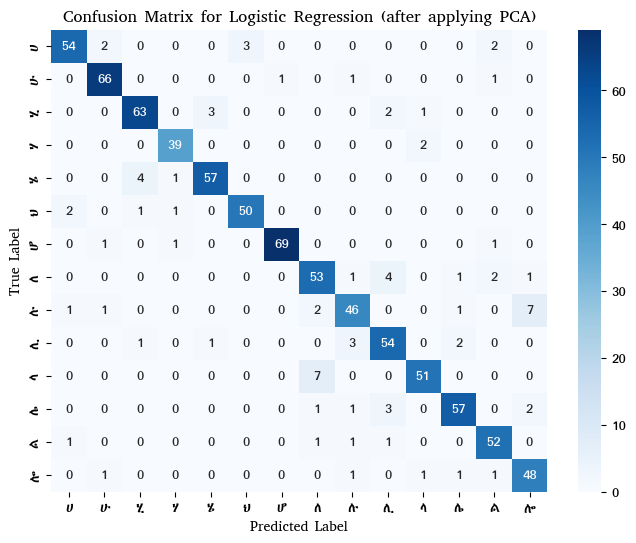


Results with after applying LDA:
SVM Results:
Accuracy: 0.9535714285714286
Precision: 0.9547909851177209
F1 Score: 0.9537381105615095


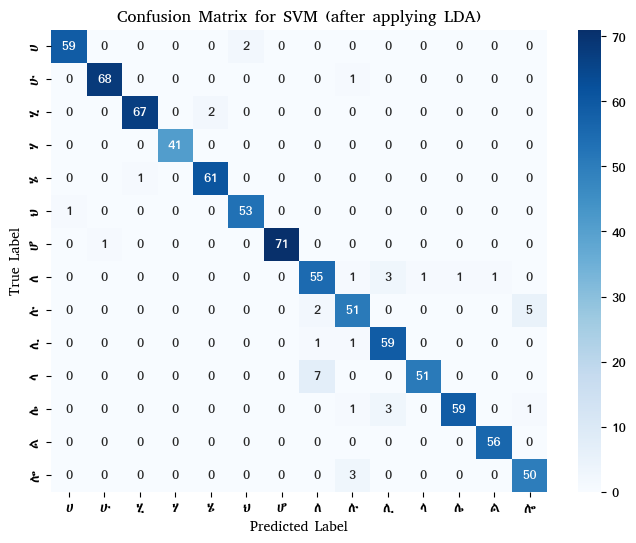


Results with after applying LDA:
KNN Results:
Accuracy: 0.8821428571428571
Precision: 0.8841469587997256
F1 Score: 0.8818743039915808


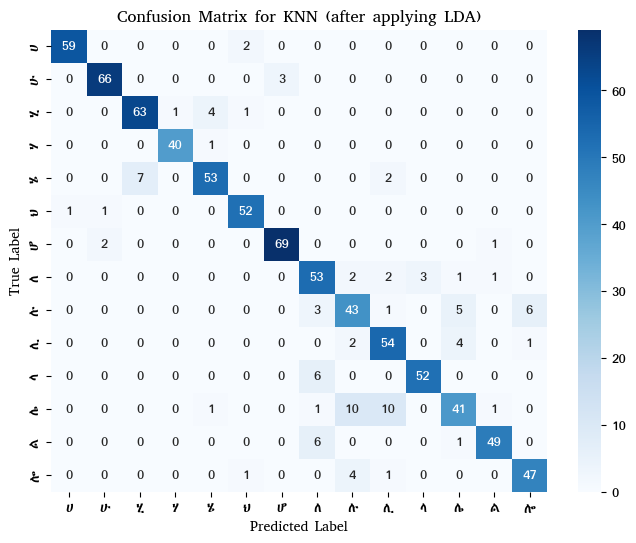


Results with after applying LDA:
Logistic Regression Results:
Accuracy: 0.9035714285714286
Precision: 0.9046946700166587
F1 Score: 0.9037401579573237


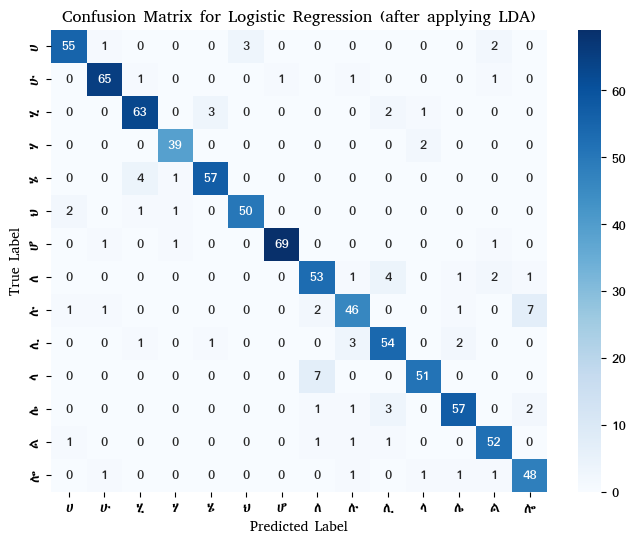

In [21]:
# Markdown: Training and Evaluating Classifiers
def evaluate(clf, train_data, train_labels, test_data, test_labels):
    clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds, average='weighted')
    f1 = f1_score(test_labels, preds, average='weighted')
    cm = confusion_matrix(test_labels, preds)
    return acc, prec, f1, cm

classifiers = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

def train_and_evaluate_classifiers(classifiers, train_data, train_labels, test_data, test_labels, data_representation):
    results = {}
    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        acc, prec, f1, cm = evaluate(clf, train_data, train_labels, test_data, test_labels)
        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "F1 Score": f1
        }
        print(f"\nResults with {data_representation}:")
        print(f"{name} Results:")
        print("Accuracy:", acc)
        print("Precision:", prec)
        print("F1 Score:", f1)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(train_labels), yticklabels=np.unique(train_labels))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {name} ({data_representation})')
        plt.show()
    return results

results_before_reduction = train_and_evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, "no dimensionality reduction")
results_after_pca = train_and_evaluate_classifiers(classifiers, transformed_x_train, y_train, transformed_x_test, y_test, "after applying PCA")
results_after_lda = train_and_evaluate_classifiers(classifiers, train_lda_projected, y_train, test_lda_projected, y_test, "after applying LDA")